# Example climb: Low Pearson correlation & low entropy

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, entropy

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [2]:
# Number of input data points
n = 5000

# Run duration in minutes
run_time = 60

# Number of replicate climbs
replicates = 4

### 1.3. Input distributions

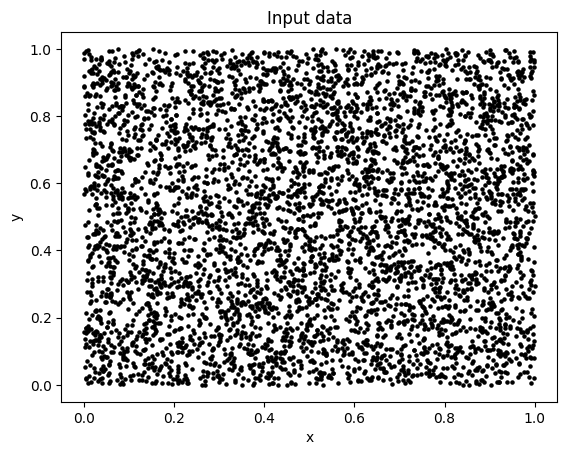

In [3]:
# Create input distribution
data = pd.DataFrame({
    'x': np.random.rand(n),
    'y': np.random.rand(n)
})

plt.title('Input data')
plt.scatter(data['x'], data['y'], s=5, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 2. Minimize correlation and entropy

### 2.1. Objective function

In [4]:
def edge_concentration_penalty(data, edge_threshold=0.05):
    """Penalize having too many points near the edges [0, 1]"""
    try:
        if len(data) < 3:
            return 0.0
        
        # Count points very close to 0 or 1
        near_zero = np.sum(data < edge_threshold)
        near_one = np.sum(data > (1.0 - edge_threshold))
        edge_count = near_zero + near_one
        
        # Penalty increases with edge concentration
        edge_fraction = edge_count / len(data)
        
        # Penalize if more than 20% of points are on edges
        if edge_fraction > 0.2:
            return (edge_fraction - 0.2) * 5.0  # Strong penalty
        return 0.0
        
    except:
        return 0.0


def outlier_penalty(data):
    try:
        if len(data) < 3:
            return 0.0

        mean_val = np.mean(data)
        std_val = np.std(data)

        if std_val == 0:
            return 0.0

        # Count points more than 2.5 standard deviations from mean
        z_scores = np.abs((data - mean_val) / std_val)
        outliers = np.sum(z_scores > 2.5)
        return outliers / len(data)

    except:
        return 0.0


def internal_structure_reward(x, y):
    """Reward configurations with varied local density (patterns, clusters, etc.)"""
    try:
        # Divide space into grid and measure density variation
        n_grid = 5
        grid_counts = np.zeros((n_grid, n_grid))
        
        # Bin points into grid
        x_bins = np.digitize(x, np.linspace(0, 1, n_grid + 1)) - 1
        y_bins = np.digitize(y, np.linspace(0, 1, n_grid + 1)) - 1
        
        # Clip to valid range
        x_bins = np.clip(x_bins, 0, n_grid - 1)
        y_bins = np.clip(y_bins, 0, n_grid - 1)
        
        # Count points in each grid cell
        for i in range(len(x)):
            grid_counts[x_bins[i], y_bins[i]] += 1
        
        # Higher variance in grid counts = more structure
        density_variance = np.var(grid_counts)
        
        # Normalize by total points
        structure_score = density_variance / (len(x) + 1)
        
        return structure_score
        
    except:
        return 0.0


def objective_low_correlation_low_entropy(x, y):
    '''Minimize both Pearson correlation and joint entropy while encouraging internal structure.
    
    Objective encourages diverse solutions with internal patterns rather than edge concentration.
    '''

    # Convert to numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Basic validation
    if len(x) == 0 or len(y) == 0 or len(x) != len(y):
        return {'error': 'invalid_input'}, -1000.0
    
    # Calculate Pearson correlation (with fallback)
    try:
        pearson_corr = pearsonr(x, y)[0]

        if np.isnan(pearson_corr):
            pearson_corr = 0.0

    except:
        pearson_corr = 0.0
    
    # Calculate joint entropy using 2D histogram
    try:
        n_bins = 20
        hist_2d, _, _ = np.histogram2d(x, y, bins=n_bins)
        hist_flat = hist_2d.flatten()
        
        if hist_flat.sum() == 0:
            joint_entropy = 0.0

        else:
            hist_prob = hist_flat / hist_flat.sum()
            joint_entropy = entropy(hist_prob + 1e-10)
            
    except:
        joint_entropy = 5.0
    
    # Add penalty for edge concentration (discourages pushing points to boundaries)
    edge_penalty_x = edge_concentration_penalty(x)
    edge_penalty_y = edge_concentration_penalty(y)
    total_edge_penalty = edge_penalty_x + edge_penalty_y
    
    # Add outlier penalty using standard deviations
    outlier_penalty_x = outlier_penalty(x)
    outlier_penalty_y = outlier_penalty(y)
    total_outlier_penalty = outlier_penalty_x + outlier_penalty_y
    
    # Encourage internal structure by rewarding moderate spread
    # (not too compact, not filling entire space)
    x_range = np.ptp(x)  # max - min
    y_range = np.ptp(y)
    
    # Ideal range is moderate use of [0,1] space (encourages clustering/patterns)
    ideal_min_range = 0.4  # At least 40% of space
    ideal_max_range = 0.8  # At most 80% of space (less than before)
    
    range_penalty = 0.0

    if x_range < ideal_min_range:
        range_penalty += (ideal_min_range - x_range) ** 2

    elif x_range > ideal_max_range:
        range_penalty += (x_range - ideal_max_range) ** 2
        
    if y_range < ideal_min_range:
        range_penalty += (ideal_min_range - y_range) ** 2

    elif y_range > ideal_max_range:
        range_penalty += (y_range - ideal_max_range) ** 2
    
    # Reward for having internal structure (measured by local density variation)
    internal_structure = internal_structure_reward(x, y)
    
    # Balanced objective with penalties and rewards
    correlation_penalty = 0.4 * abs(pearson_corr)  # Slightly increased weight
    entropy_penalty = 0.4 * joint_entropy  # Slightly increased weight
    outlier_penalty_weighted = 0.8 * total_outlier_penalty  # Reduced from 1.0
    range_penalty_weighted = 0.5 * range_penalty  # Increased from 0.3
    edge_penalty_weighted = 2.0 * total_edge_penalty  # Strong penalty for edges
    structure_reward = 0.3 * internal_structure  # Reward internal structure
    
    objective = -(correlation_penalty + entropy_penalty + outlier_penalty_weighted + 
                  range_penalty_weighted + edge_penalty_weighted) + structure_reward
    
    metrics = {
        'Pearson coefficient': float(pearson_corr),
        'Joint Entropy': float(joint_entropy),
        'Outlier Penalty': float(total_outlier_penalty),
        'Range Penalty': float(range_penalty),
        'Edge Penalty': float(total_edge_penalty),
        'Internal Structure': float(internal_structure),
        'Combined Score': float(correlation_penalty + entropy_penalty)
    }
    
    return metrics, float(objective)

### 2.2. Run parameters

In [5]:
# Set hyperparameters for diversity and internal structure
step_size = 0.5  # Reduced for more controlled exploration
perturb_fraction = 0.15  # Reduced to allow gradual evolution
temperature = 500.0  # Higher temperature for more exploration
initial_noise = 0.5  # Higher initial diversity between replicates
cooling_rate = 0.9995  # Slower cooling to maintain diversity longer
objective_func = objective_low_correlation_low_entropy

### 2.3. Hill climbing run

In [ ]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_func,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.4. Results

In [ ]:
# Display key metrics including new edge penalty and internal structure
climber.plot_results(
    results,
    metrics=[
        'Joint Entropy',
        'Edge Penalty',
        'Internal Structure',
        'Pearson coefficient'
    ]
)

In [ ]:
# Save the climber object
with open('../data/04_low_correlation_low_entropy.pkl', 'wb') as f:
    pickle.dump(climber, f)